**Project: Time Series Analysis**

In [1]:
from dateutil.relativedelta import relativedelta
from scipy.signal import savgol_filter

In [2]:
# data analysis stack
import numpy as np
import pandas as pd

# data visualization stack
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('whitegrid')

# machine learning stack
from sklearn.preprocessing import (
    PolynomialFeatures,
    OneHotEncoder
)
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_squared_error


# time-related stack
from datetime import datetime as dt

# miscellaneous
import warnings
warnings.filterwarnings("ignore")

# statistics stack
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose

import pmdarima as pm

**Lots of functions god knows what they are doing**

In [3]:
def p_values(series):
    """
    returns p-values for ADF and KPSS Tests on a time series
    """
    # p value from Augmented Dickey-Fuller (ADF) Test
    p_adf = adfuller(series, autolag="AIC")[1]
    
    # p value from Kwiatkowski–Phillips–Schmidt–Shin (KPSS) Test
    p_kpss = kpss(series, regression="c", nlags="auto")[1]
    
    return round(p_adf,6), round(p_kpss,6)

In [4]:
def test_stationarity(series):
    """
    returns likely conclusions about series stationarity
    """
    # test heteroscedasticity with qcd
    qcd = qcd_variance(series)
    
    if qcd >= 0.50:
        print(f"\n non-stationary: heteroscedastic (qcd = {qcd}) \n")
    
    # test stationarity
    else:
        p_adf, p_kpss = p_values(series)
        
        # print p-values
        print( f"\n p_adf: {p_adf}, p_kpss: {p_kpss}" )
    
        if (p_adf < 0.01) and (p_kpss >= 0.05):
            print('\n stationary or seasonal-stationary')
            
        elif (p_adf >= 0.1) and (p_kpss < 0.05):
            print('\n difference-stationary')
            
        elif (p_adf < 0.1) and (p_kpss < 0.05):
            print('\n trend-stationary')
        
        else:
            print('\n non-stationary; no robust conclusions\n')

In [5]:
def auto_correlation_plot(series):
    """
    plots autocorrelations for a given series
    """
    mpl.rc('figure',figsize=(10,2),dpi=200)
    plot_acf(series,zero=False,lags=25)
    plt.xlabel('number of lags')
    plt.ylabel('autocorrelation')

In [6]:
def partial_auto_correlation_plot(series):
    """
    plots partial autocorrelations for a given series
    """
    mpl.rc('figure',figsize=(10,2),dpi=200)
    plot_pacf(series,zero=False,lags=25)
    plt.xlabel('number of lags')
    plt.ylabel('partial autocorrelation')

**Loading data and stating finally**

EUROPEAN CLIMATE ASSESSMENT & DATASET (ECA&D), file created on 08-05-2023
THESE DATA CAN BE USED FREELY PROVIDED THAT THE FOLLOWING SOURCE IS ACKNOWLEDGED:

Klein Tank, A.M.G. and Coauthors, 2002. Daily dataset of 20th-century surface
air temperature and precipitation series for the European Climate Assessment.
Int. J. of Climatol., 22, 1441-1453.
Data and metadata available at http://www.ecad.eu

FILE FORMAT (MISSING VALUE CODE IS -9999):

01-06 SOUID: Source identifier
08-15 DATE : Date YYYYMMDD
17-21 TG   : mean temperature in 0.1 &#176;C
23-27 Q_TG : Quality code for TG (0='valid'; 1='suspect'; 9='missing')

This is the blended series of station GERMANY, BERLIN-TEMPELHOF (STAID: 2759).
Blended and updated with sources: 111448 127488 128124 
See file sources.txt and stations.txt for more info.

In [7]:
# load data txt file as a dataframe

df = pd.read_csv(
    "./data/TG_STAID002759.txt",
    # data starts from line 20
    skiprows = 19,
    # remove empty space in column name
    skipinitialspace = True,
    # parse DATE column 1
    parse_dates = [1],
)

In [8]:
df.tail()

,SOUID,DATE,TG,Q_TG
53776,111448,2023-03-27,34,0
53777,111448,2023-03-28,35,0
53778,111448,2023-03-29,66,0
53779,111448,2023-03-30,117,0
53780,111448,2023-03-31,108,0


In [9]:
# Missing data will be filled with the mean of 5 years of preceding and 5 years of following data points.

In [10]:
df_missing = df[df["Q_TG"]==9]

In [11]:
df_missing["DATE"].min()

Timestamp('1945-04-25 00:00:00')

In [12]:
df_missing["DATE"].max()

Timestamp('1945-11-05 00:00:00')

In [13]:
missing_days = (df_missing["DATE"].max()-df_missing["DATE"].min()).days + 1
missing_days

195

In [14]:
missing_days == df_missing.shape[0]

True

In [15]:
# reference years are all years 5 years before and  5 years after
reference_years = list(range(-5,6))
reference_years.remove(0)
# function for clean temperature values
def clean_temp(df,x):
    """
    returns a temperaure column in celcius with missing values imputed;
    imputation is done with the average of the temperautes on the same
    day over all the reference years; division by 10 for celcius value
    """
    # if missing value occurs
    if x['Q_TG']==9:
        # list reference dates
        reference_dates = [x['DATE']+relativedelta(years=y) for y in reference_years]
        # mean temperatue over the references dates
        temp_value = df[df['DATE'].isin(reference_dates)]['TG'].mean()
        # division by 10 to convert to celcius value
        return int(temp_value)/10
    # else just division by 10 to convert to celcius value
    return x['TG']/10



In [16]:
# create clean temperatutre column
df['TEMP'] = df.apply(
    lambda x: clean_temp(df,x),
    axis=1
)

In [17]:
df.isna().count()

SOUID    53781
DATE     53781
TG       53781
Q_TG     53781
TEMP     53781
dtype: int64

In [18]:
df.shape

(53781, 5)

In [19]:
df.columns=df.columns.str.lower()
clean_df=df.set_index("date")[["temp"]]

In [20]:
clean_df.head()

,temp
date,
1876-01-01,2.2
1876-01-02,2.5
1876-01-03,0.3
1876-01-04,-5.8
1876-01-05,-9.8


In [21]:
# Data is splited from the beginning to 2022-12-31. Last 3 monts will be the test data
train= clean_df[:"2022-12-31"]
test= clean_df["2023-01-01":]

In [22]:
train.shape

(53691, 1)

In [23]:
test.shape

(90, 1)

In [24]:
#train.to_csv("./data/train.csv")
#test.to_csv("./data/test.csv")

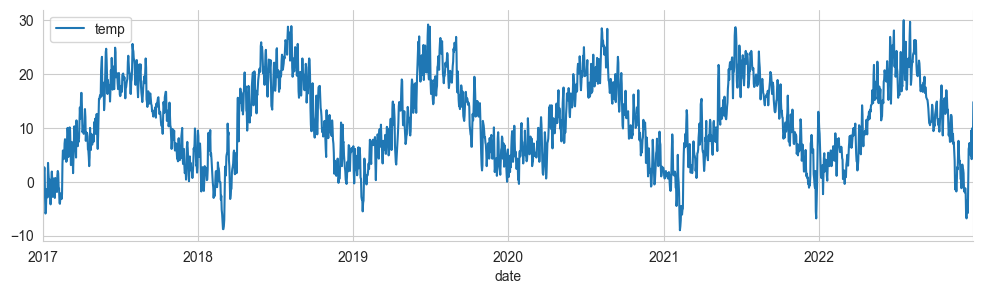

In [25]:
# plot the last 5 years
train_last_five = train["2017-01-01":]

mpl.rc('figure',figsize=(12,3),dpi=100)

train_last_five['temp'].plot(legend=True)
sns.despine()

In [26]:
# savitzky-golary filter will be used to filter the noise
train['denoised'] = savgol_filter(np.array(train['temp']), 99, 3, mode = 'nearest')
train['noise'] = train['temp'] - train['denoised']


In [27]:
print(train['denoised'])

date
1876-01-01   -0.659391
1876-01-02   -0.772946
1876-01-03   -0.858296
1876-01-04   -1.025494
1876-01-05   -1.151521
                ...   
2022-12-27    6.827954
2022-12-28    7.212065
2022-12-29    7.611574
2022-12-30    8.021626
2022-12-31    8.411407
Name: denoised, Length: 53691, dtype: float64


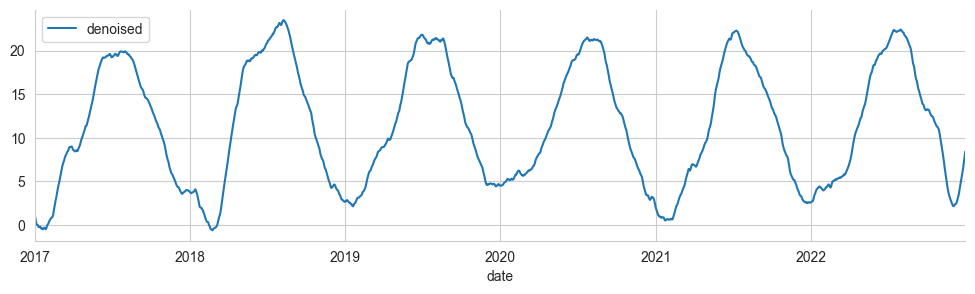

In [28]:
# plot the last 5 years
train_denoised_five = train["2017-01-01":]

mpl.rc('figure', figsize=(12,3), dpi=100)

train_denoised_five['denoised'].plot(legend=True)
sns.despine()



**DENOISED DATA**


In [29]:
train.head()

,temp,denoised,noise
date,,,
1876-01-01,2.2,-0.659391,2.859391
1876-01-02,2.5,-0.772946,3.272946
1876-01-03,0.3,-0.858296,1.158296
1876-01-04,-5.8,-1.025494,-4.774506
1876-01-05,-9.8,-1.151521,-8.648479


In [30]:
train['timestep'] = list(range(train.shape[0]))

**Trend Model**

In [31]:
X_trend_denoised = train[['timestep']]
y_trend_denoised = train['denoised']

In [32]:
X_trend_denoised.shape

(53691, 1)

In [33]:
# trend model for denoised data 
trend_model_de = make_pipeline(
    PolynomialFeatures(degree=2),
    LinearRegression()
)

In [34]:
trend_model_de.fit(X_trend_denoised,y_trend_denoised)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures()),
                ('linearregression', LinearRegression())])

In [35]:
train['trend_pred'] = trend_model_de.predict(X_trend_denoised)
train['trend_pred']

date
1876-01-01     9.234793
1876-01-02     9.234747
1876-01-03     9.234700
1876-01-04     9.234653
1876-01-05     9.234606
                ...    
2022-12-27    11.085904
2022-12-28    11.086020
2022-12-29    11.086135
2022-12-30    11.086251
2022-12-31    11.086367
Name: trend_pred, Length: 53691, dtype: float64

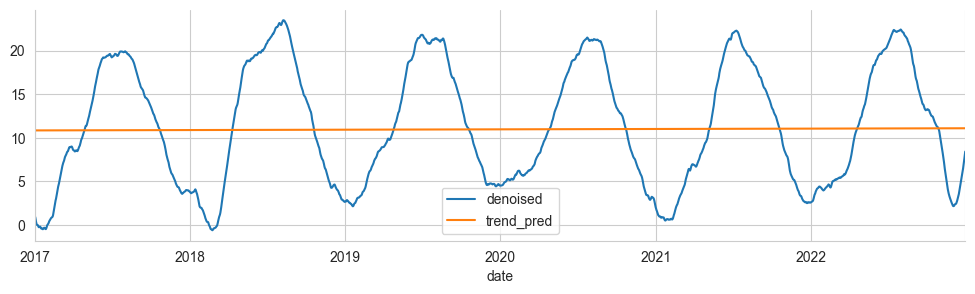

In [37]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['denoised','trend_pred']]["2017-01-01":].plot(legend=True)
sns.despine()

In [38]:
train.head()

,temp,denoised,noise,timestep,trend_pred
date,,,,,
1876-01-01,2.2,-0.659391,2.859391,0,9.234793
1876-01-02,2.5,-0.772946,3.272946,1,9.234747
1876-01-03,0.3,-0.858296,1.158296,2,9.234700
1876-01-04,-5.8,-1.025494,-4.774506,3,9.234653
1876-01-05,-9.8,-1.151521,-8.648479,4,9.234606


**Seasonality model**

In [40]:
train['detrended_de'] = train['denoised'] - train['trend_pred']

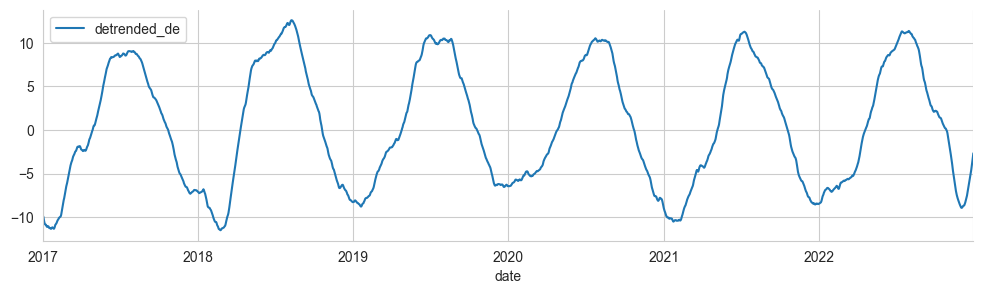

In [41]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['detrended_de']["2017-01-01":].plot(legend=True)
sns.despine()

In [42]:
train["day_of_year"] = train.index.dayofyear 
#train["sin_day_of_year"] = np.sin(2*np.pi*train["day_of_year"]/365.24) 
#train["cos_day_of_year"] = np.cos(2*np.pi*train["day_of_year"]/365.24)

In [43]:
train.head()

,temp,denoised,noise,timestep,trend_pred,detrended_de,day_of_year
date,,,,,,,
1876-01-01,2.2,-0.659391,2.859391,0,9.234793,-9.894184,1
1876-01-02,2.5,-0.772946,3.272946,1,9.234747,-10.007693,2
1876-01-03,0.3,-0.858296,1.158296,2,9.234700,-10.092996,3
1876-01-04,-5.8,-1.025494,-4.774506,3,9.234653,-10.260147,4
1876-01-05,-9.8,-1.151521,-8.648479,4,9.234606,-10.386128,5


In [44]:
X_seasonality_de = train[['day_of_year']]
y_seasonality_de = train['detrended_de']

In [45]:
# seasonality model
seasonality_model = make_pipeline(
    OneHotEncoder(drop='first'),
    LinearRegression()
)

In [46]:
seasonality_model.fit(X_seasonality_de, y_seasonality_de)

Pipeline(steps=[('onehotencoder', OneHotEncoder(drop='first')),
                ('linearregression', LinearRegression())])

In [47]:
train['seasonality_pred'] = seasonality_model.predict(X_seasonality_de)
train['seasonality_pred']

date
1876-01-01   -9.067679
1876-01-02   -9.103861
1876-01-03   -9.141828
1876-01-04   -9.176523
1876-01-05   -9.206905
                ...   
2022-12-27   -8.820279
2022-12-28   -8.848868
2022-12-29   -8.883836
2022-12-30   -8.922330
2022-12-31   -8.965668
Name: seasonality_pred, Length: 53691, dtype: float64

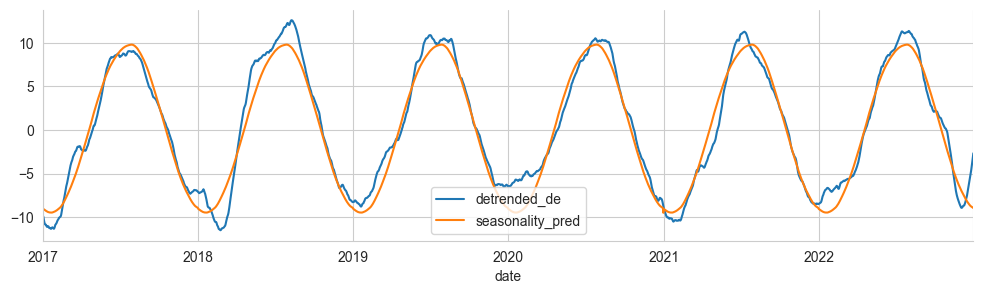

In [53]:
#add something to plot just last 5 years.
mpl.rc('figure',figsize=(12,3),dpi=100)

train[['detrended_de','seasonality_pred']]["2017-01-01":].plot(legend=True)
sns.despine()

In [54]:
train.head()

,temp,denoised,noise,timestep,trend_pred,detrended_de,day_of_year,seasonality_pred,remainder_de
date,,,,,,,,,
1876-01-01,2.2,-0.659391,2.859391,0,9.234793,-9.894184,1,-9.067679,8.408288
1876-01-02,2.5,-0.772946,3.272946,1,9.234747,-10.007693,2,-9.103861,8.330915
1876-01-03,0.3,-0.858296,1.158296,2,9.234700,-10.092996,3,-9.141828,8.283532
1876-01-04,-5.8,-1.025494,-4.774506,3,9.234653,-10.260147,4,-9.176523,8.151028
1876-01-05,-9.8,-1.151521,-8.648479,4,9.234606,-10.386128,5,-9.206905,8.055384


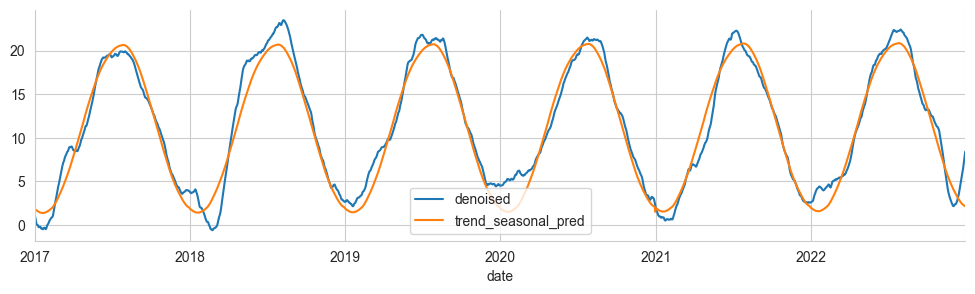

In [56]:
# combine trend and seasonality

train['trend_seasonal_pred'] = train['trend_pred'] + train['seasonality_pred']

mpl.rc('figure',figsize=(12,3),dpi=100)
train[['denoised','trend_seasonal_pred']]["2017-01-01":].plot(legend=True)
sns.despine()

**REMAINDER**

In [57]:
train['remainder_de'] = train['denoised'] - train['trend_seasonal_pred']

In [58]:
def qcd_variance(series,window=12):
    """
    This function returns the quartile coefficient of dispersion
    of the rolling variance of a series in a given window range 
    """
    # rolling variance for a given window 
    variances = series.rolling(window).var().dropna()
    # first quartile
    Q1 = np.percentile(variances, 25, interpolation='midpoint')
    # third quartile
    Q3 = np.percentile(variances, 75, interpolation='midpoint')
    # quartile coefficient of dispersion 
    qcd = round((Q3-Q1)/(Q3+Q1),6)
    
    print(f"quartile coefficient of dispersion: {qcd}")

In [59]:
# quartile coefficient of dispersion
qcd_variance(train['remainder_de'])

quartile coefficient of dispersion: 0.756349


In [ ]:
#temp_remainder = train['remainder_de'].reset_index()
#temp_remainder.to_csv('./data/temp_remainder.csv',index=False)

In [ ]:
#df = pd.read_csv("./data/temp_remainder.csv").set_index('date')
#df.tail()

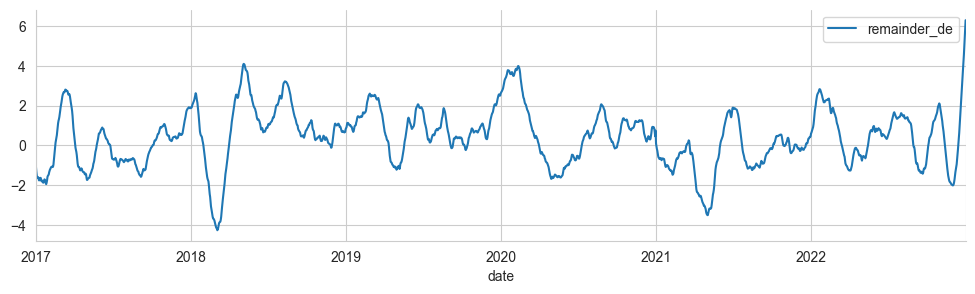

In [60]:
mpl.rc('figure',figsize=(12,3),dpi=100)

train['remainder_de']["2017-01-01":].plot(legend=True)
sns.despine()

In [61]:
arima_model = pm.auto_arima(
    train['remainder_de'],
    seasonality = False,
    stationarity = False,
    d=None,
    trace = True,
    n_jobs=-1
)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=-155910.608, Time=29.24 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=211090.848, Time=1.11 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=inf, Time=10.83 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=138235.240, Time=12.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=211088.848, Time=0.50 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-142583.534, Time=21.46 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-155759.746, Time=24.57 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=-155027.318, Time=93.64 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=-156154.934, Time=30.69 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=-147878.158, Time=21.76 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=-156272.400, Time=70.72 sec
 ARIMA(4,0,3)(0,0,0)[0] intercept   : AIC=-156315.840, Time=21.88 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=-155433.955, Time=106.71 sec
 ARIMA(5,0,3)(0,0,0)[0] intercept   : AIC=-156324.427, Time

In [62]:
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                53691
Model:               SARIMAX(5, 0, 3)   Log Likelihood               78172.499
Date:                Thu, 11 May 2023   AIC                        -156326.998
Time:                        22:49:12   BIC                        -156246.979
Sample:                    01-01-1876   HQIC                       -156302.015
                         - 12-31-2022                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.8416      0.216      8.518      0.000       1.418       2.265
ar.L2         -0.7932      0.453     -1.751      0.080      -1.681       0.095
ar.L3          0.3174      0.338      0.940      0.347      -0.345       0.980
ar.L4         -0.6738      0.296     -2.280      0.023      -1.253      -0.095
ar.L5          0.3064      0.107      2.853      0.004       0.096       0.517
ma.L1         -0.1091      0.216     -0.505      0.614      -0.533       0.314
ma.L2         -0.0927      0.134     -0.693      0.489      -0.355       0.170
ma.L3         -0.4453      0.145     -3.068      0.002      -0.730      -0.161
sigma2         0.0032   8.33e-06    381.819      0.000       0.003       0.003
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):           3434870.61
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                            -1.68
Prob(H) (two-sided):                  0.05   Kurtosis:                        42.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [63]:
train["remainder_pred"]=arima_model.predict()

**NOISE**

**FINALLY**

In [ ]:
train['over_all_pred'] = train['trend_pred'] + train['seasonality_pred'] + train["remainder_pred"]
